# Landscape Evolution Modeling

A showcase of xarray-simlab in the context of landscape evolution modeling (an almost real world example).

In [1]:
import numpy as np
import xarray as xr
import xrsimlab

## Import and inspect a model

The model (i.e., the `xrsimlab.Model` object) that we use here is provided by the [xarray-topo](https://gitext.gfz-potsdam.de/sec55-public/xarray-topo) package.

In [2]:
from xrtopo.models.fastscape_base import fastscape_base_model

This 2-dimensional model simulates the long-term evolution of topographic surface elevation (hereafter noted $h$). The local rate of elevation change, $\partial h/\partial t$, is determined by the balance between uplift (uniform in space and time) $U$ and erosion $E$.

$$\frac{\partial h}{\partial t} = U - E$$

Erosion (river channels) is given by the stream power law:

$$E = K A^m (\nabla h)^n$$

where $A$ is the drainage area and $K$, $m$ and $n$ are parameters.

We can see these parameters - as well as the initial elevation surface and the grid parameters - as model inputs in the `repr`.

In [3]:
fastscape_base_model

<xrsimlab.Model (9 processes, 13 inputs)>
grid
    x_size     (in) nb. of nodes in x
    y_size     (in) nb. of nodes in y
    x_length   (in) total grid length in x
    y_length   (in) total grid length in y
    x_spacing  (in) node spacing in x
    y_spacing  (in) node spacing in y
    x_origin   (in) grid x-origin
    y_origin   (in) grid y-origin
boundaries
uplift
    u_coef     (in) uplift rate
flow_routing
area
spower
    k_coef     (in) stream-power constant
    m_exp      (in) stream-power drainage area exponent
    n_exp      (in) stream-power slope exponent
erosion
exhumation
topography
    elevation  (in) topographic elevation

To have a better picture of all processes (and inputs and/or variables) in the model, we can visualize it as a graph. Processes are in blue and inputs are in yellow.

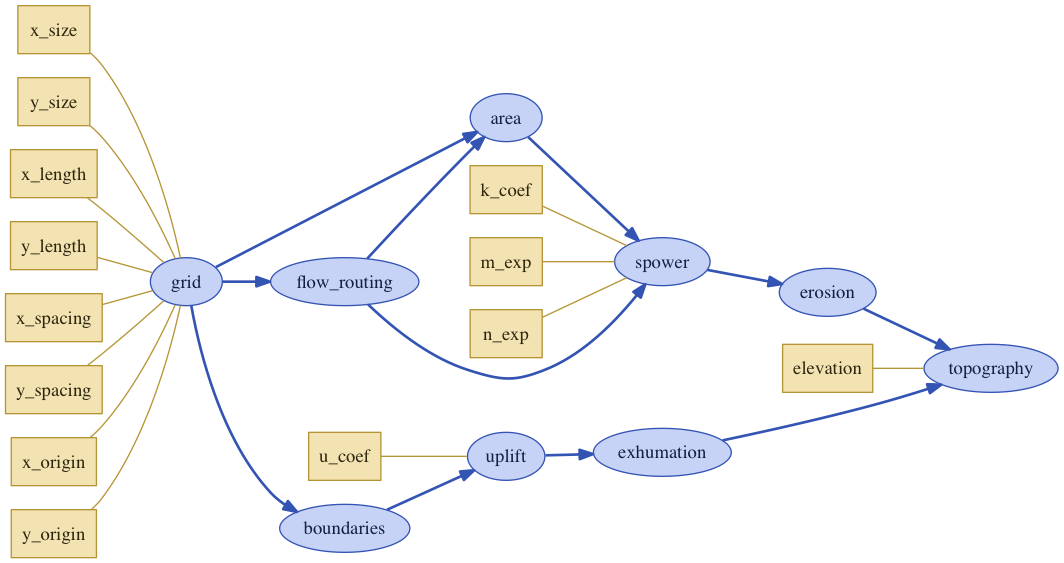

In [4]:
fastscape_base_model.visualize(show_inputs=True)

Note that in this model the 2-dimensional grid is actually stacked on the 'node' dimension, as shown below for the `x` and `y` variables. This is required by some of the algorithms implemented in it.

In [5]:
fastscape_base_model.grid

<xrsimlab.Process 'xrtopo.models.fastscape_base.StackedGridXY'>
Variables:
    x_size     IntegerVariable ()
    y_size     IntegerVariable ()
    x_length   FloatVariable ()
    y_length   FloatVariable ()
    x_spacing  FloatVariable ()
    y_spacing  FloatVariable ()
    x_origin   FloatVariable ()
    y_origin   FloatVariable ()
  * x          Variable ('node')
  * y          Variable ('node')
Meta:
    time_dependent: False

## Create a model setup

With a few lines of code, using the `Dataset.simlab` extension (accessor), we create the setup of a new simulation, starting from an empty `Dataset`.

In [6]:
# create a new Dataset
ds = xr.Dataset()   

# use the model above with this Dataset
ds.simlab.use_model(fastscape_base_model) 

# populate Dataset with input variable values (per process in the model)
ds.simlab.set_input_vars('grid', x_size=101, y_size=101, x_length=1e5, y_length=1e5)
ds.simlab.set_input_vars('topography', elevation=('node', np.random.rand(101 * 101)))
ds.simlab.set_input_vars('spower', k_coef=7e-5, m_exp=0.4, n_exp=1)
ds.simlab.set_input_vars('uplift', u_coef=2e-3)

# set the clock coordinate where labels are time steps (here in years)
ds.simlab.set_master_clock('time', end=1e6, step=1e3)

We want to save topography elevation values as output (snapshots), but not at every time step. 

In [7]:
# set another time coordinate for snapshots with much larger steps than for 'time'
ds.simlab.set_snapshot_clock('out', end=1e6, step=1e5)

# use the last created time coordinate to save topographic elevation values
ds.simlab.set_snapshot_vars('out', topography='elevation')

We also want to save the $x$ and $y$ coordinates of the grid.

In [8]:
# use None for saving time-independent outputs
ds.simlab.set_snapshot_vars(None, grid=['x', 'y'])

The Dataset now looks like

In [9]:
ds

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    topography__elevation  (node) float64 0.7618 0.06954 0.7658 0.02725 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
Attributes:
    _simlab_snapshot_vars: grid__x,grid__y

If they are defined, the metadata (e.g., description, units, math_symbol...) associated to each input variable in the model are added as attributes of the data variables of the dataset, e.g.,

In [32]:
ds.spower__k_coef

<xarray.DataArray 'spower__k_coef' ()>
array(7e-05)
Attributes:
    description: stream-power constant

## Run the model

We run the model simply by calling `Dataset.simlab.run()`, which returns a new Dataset with both the inputs and the outputs. Note the additional variables `grid__x` and `grid__y` and the `topography__elevation` variable which has now also the `out` dimension. 

In [10]:
out_ds = ds.simlab.run()

out_ds

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    topography__elevation  (out, node) float64 0.7618 0.06954 0.7658 0.02725 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
    grid__x                (node) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
    grid__y                (node) float64 0.0 0.0 0.0 0.0 0.0 0

## Analyse, plot and save the results

We can then use all the nice features of xarray to directly analyse, process, plot and/or write to disk (e.g., in a netCDF file) the simulation data obtained at the previous step.

In this case, before doing any further processing it is much more convenient to first represent the data using the two spatial dimensions. This may be easily done with xarray:

In [11]:
out_ds_unstack = out_ds.set_index(node=['grid__x', 'grid__y']).unstack('node')

The resulting Dataset has no `node` dimension anymore but has `grid__x` and `grid__y` dimensions instead.  

In [12]:
out_ds_unstack

<xarray.Dataset>
Dimensions:                (grid__x: 101, grid__y: 101, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
  * grid__x                (grid__x) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
  * grid__y                (grid__y) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    topography__elevation  (out, grid__x, grid__y) float64 0.7618 0.1694 ...
    spower__k_coef         float64 7e-05
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002

We can then plot the data, e.g., here below the elevation values at the end of the simulation:

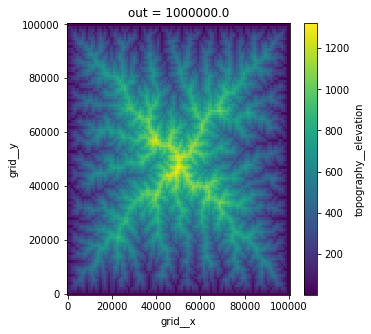

In [13]:
%matplotlib inline

xr.plot.pcolormesh(out_ds_unstack.isel(out=-1).topography__elevation.T,
                   size=5, aspect=1);

xarray datasets can be used with [Holoview](http://holoviews.org/), a plotting package that is really helpful for quickly and interactively exploring multi-dimensional data.

In [14]:
import holoviews as hv

hv.notebook_extension('matplotlib')

We can for example see below how the relief is created during the simulation (snapshots are taken every 100000 years and elevation values are in meters).

**Note:** There may be issues with rendering Holoview interactive visualizations if you are on xarray-simlab's documentation. Fortunately you should be able to see this page as a notebook properly rendered on [nbviewer.org](http://nbviewer.jupyter.org/github/benbovy/xarray-simlab/blob/master/doc/examples/landscape-evolution-model.ipynb).

b':HoloMap   [out]\n   :Image   [grid__x,grid__y]   (topography__elevation)'
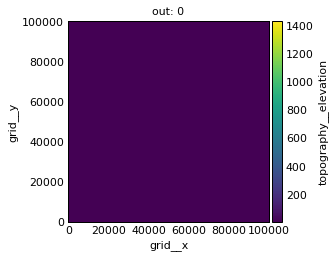
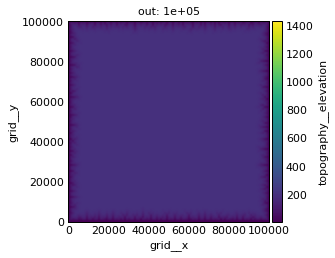
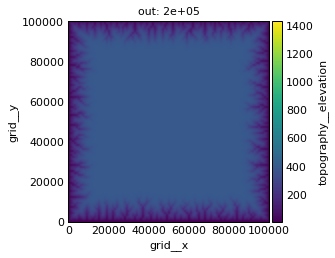
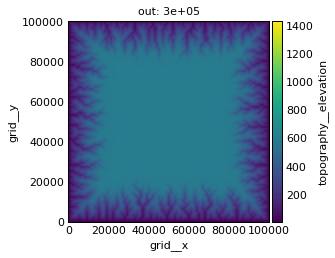
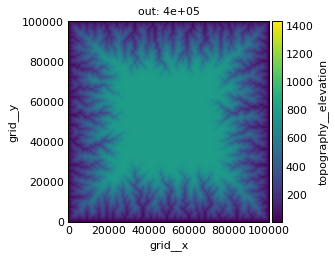
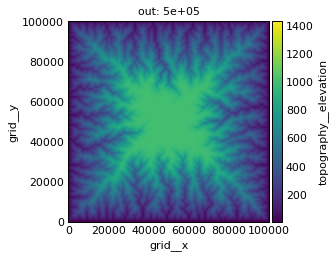
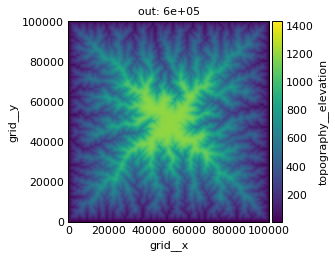
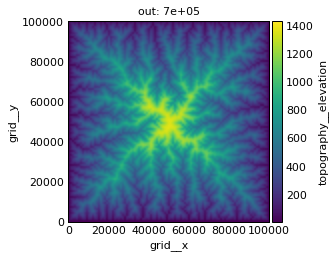
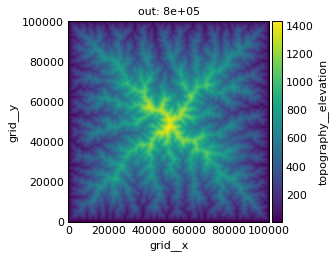
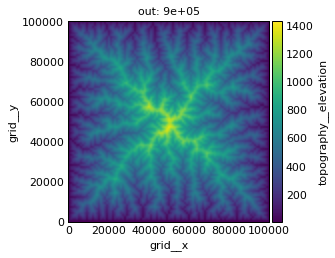
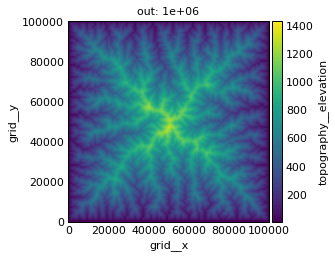

In [15]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_unstack.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])

Additionally, We can compute derived quantities without much effort. Here below we calculate the surface denudation rates (in m/yr) averaged over each time steps of the output `out` dimension. 

In [16]:
def denudation_rate(ds, time_dim='out'):
    topo = ds.topography__elevation
    dt = ds[time_dim].diff(time_dim)
    den_rate = topo.diff(time_dim) / dt - ds.uplift__u_coef
    return den_rate

In [17]:
den_rate = denudation_rate(out_ds_unstack)

We further compute and plot the spatially averaged denudation rate.

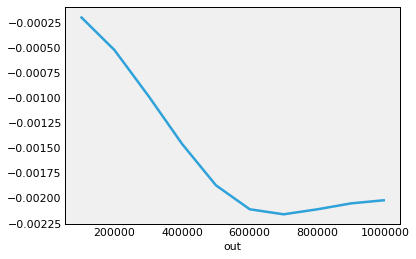

In [18]:
den_rate.mean(('grid__x', 'grid__y')).plot();

## Run the model with time-varying parameter values

Instead of providing constant, scalar values for model inputs, it is possible to provide arrays which have the same dimension as the one used for the "master clock" (the `time` dimension in this case).

As an example, we try below a sinusoidal variation for the $K$ parameter of the stream power law, with a period of 400000 years.

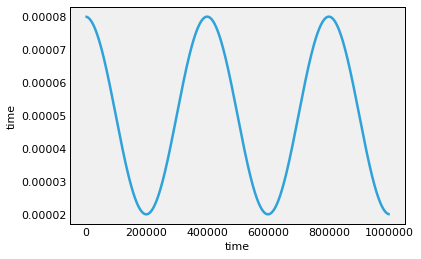

In [19]:
da_k_time = 5e-5 + 3e-5 * np.cos((2 * np.pi / 4e5) * ds.time)

da_k_time.plot()

Using a copy of the input Dataset used above, we reset the input values for the `spower` process. Note the `time` dimension of the `spower__k_coef` variable.

In [20]:
ds_kt = ds.copy()

# we copied the dataset so we need to explicitly re-assign the Model
ds_kt.simlab.use_model(fastscape_base_model)

ds_kt.simlab.set_input_vars('spower', k_coef=da_k_time, m_exp=0.4, n_exp=1)

ds_kt

<xarray.Dataset>
Dimensions:                (node: 10201, out: 11, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
Dimensions without coordinates: node
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    topography__elevation  (node) float64 0.7618 0.06954 0.7658 0.02725 ...
    spower__k_coef         (time) float64 8e-05 8e-05 7.999e-05 7.997e-05 ...
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
Attributes:
    _simlab_snapshot_vars: grid__x,grid__y

We then run the model, unstack the spatial dimensions, compute the denudation rates and plot the spatial averages that we can compare with the results from the previous run. We clearly see the impact of the time-varying $K$ parameter values on the denudation rates. 

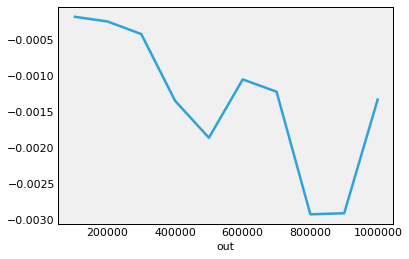

In [21]:
out_ds_kt = ds_kt.simlab.run()

out_ds_kt_unstack = out_ds_kt.set_index(node=['grid__x', 'grid__y']).unstack('node')

den_rate_kt = denudation_rate(out_ds_kt_unstack)

den_rate_kt.mean(('grid__x', 'grid__y')).plot();

## Run and combine different model setups

Here is an brief example of running the model multiple times for different constant values of $K$ and then concatenate the results into a single dataset. In next versions of xarray-simlab, this process will be even simpler.

In [22]:
k_values = [5e-5, 6e-5, 7e-5]
datasets_k = []
    
ds_in = ds.copy()
ds_in.simlab.use_model(fastscape_base_model)

for k in k_values:
    print('run k=%f' % k)

    ds_in.simlab.set_input_vars('spower', k_coef=k, m_exp=0.4, n_exp=1)
    out_ds = ds_in.simlab.run()

    datasets_k.append(out_ds)

out_ds_concat = xr.concat(datasets_k, dim='spower__k_coef', data_vars='different')

run k=0.000050
run k=0.000060
run k=0.000070


We repeat the same operation than above to get back the data in 2 spatial dimensions. 

In [23]:
out_ds_concat_unstack = out_ds_concat.set_index(
    node=['grid__x', 'grid__y']).unstack('node')

Note the additional `spower__k_coef` dimension, which has its own index coordinate with labels corresponding to the $K$ values.

In [24]:
out_ds_concat_unstack

<xarray.Dataset>
Dimensions:                (grid__x: 101, grid__y: 101, out: 11, spower__k_coef: 3, time: 1001)
Coordinates:
  * time                   (time) float64 0.0 1e+03 2e+03 3e+03 4e+03 5e+03 ...
  * out                    (out) float64 0.0 1e+05 2e+05 3e+05 4e+05 5e+05 ...
  * spower__k_coef         (spower__k_coef) float64 5e-05 6e-05 7e-05
  * grid__x                (grid__x) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
  * grid__y                (grid__y) float64 0.0 1e+03 2e+03 3e+03 4e+03 ...
Data variables:
    grid__x_size           int64 101
    grid__y_size           int64 101
    grid__x_length         float64 1e+05
    grid__y_length         float64 1e+05
    grid__x_spacing        float64 1e+03
    grid__y_spacing        float64 1e+03
    grid__x_origin         float64 0.0
    grid__y_origin         float64 0.0
    spower__m_exp          float64 0.4
    spower__n_exp          int64 1
    uplift__u_coef         float64 0.002
    topography__elevation  (spower__k_coef, 

This new dimension also appears in the Holoview figure

b':HoloMap   [out,spower__k_coef]\n   :Image   [grid__x,grid__y]   (topography__elevation)'
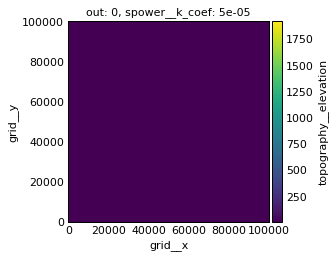
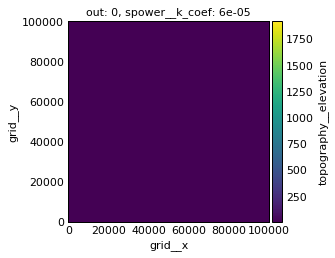
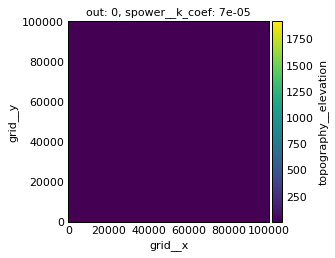
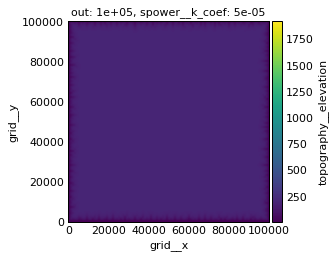
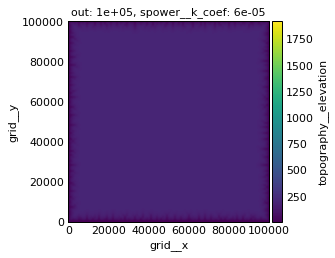
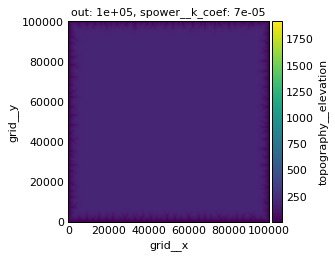
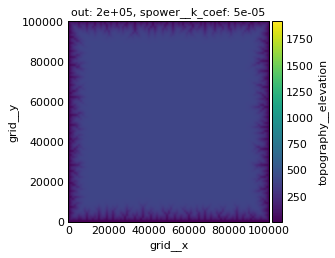
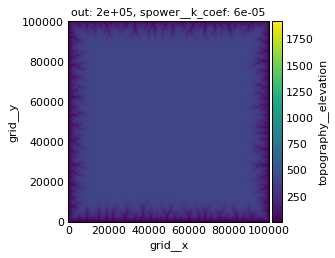
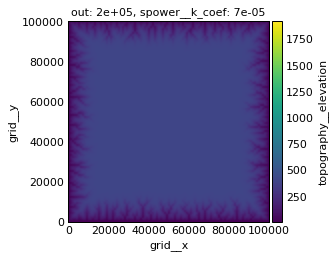
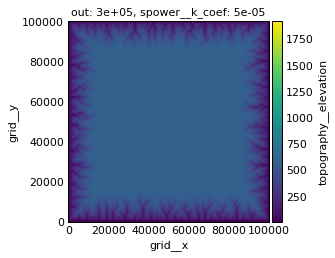
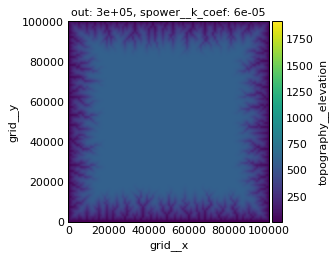
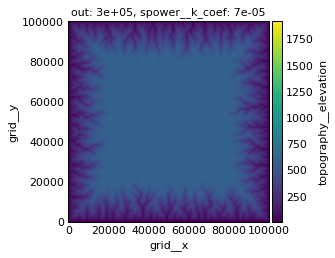
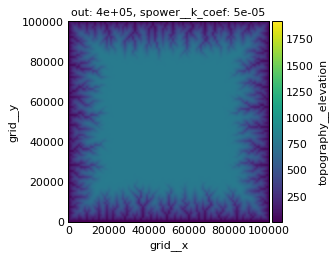
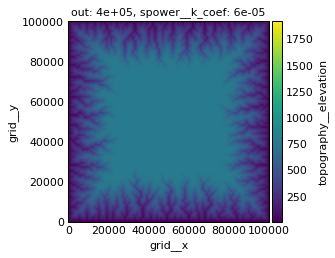
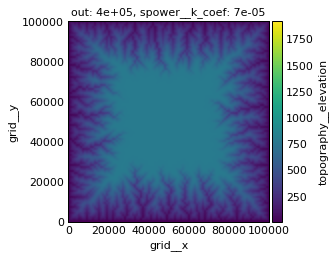
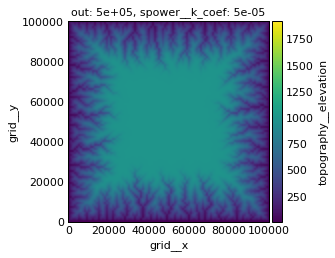
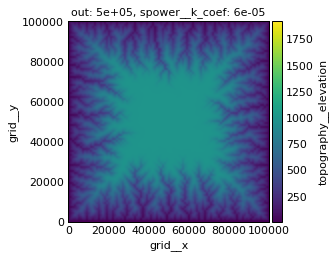
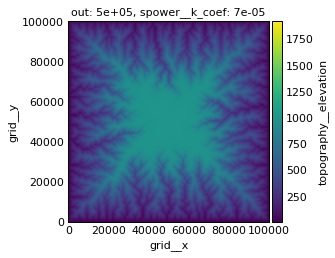
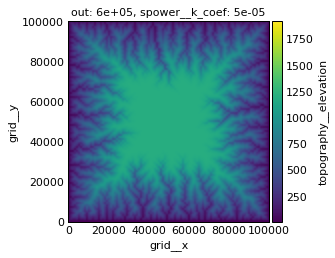
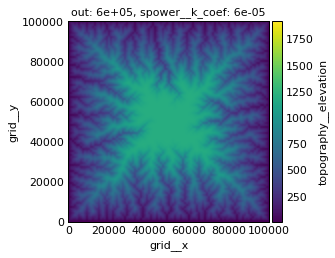
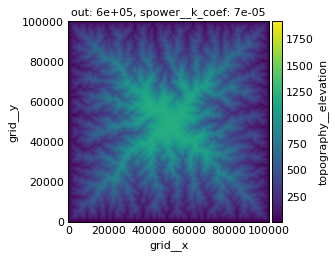
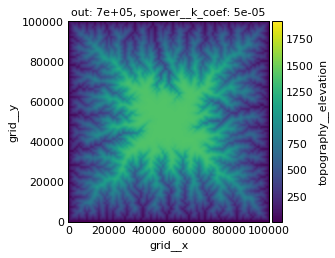
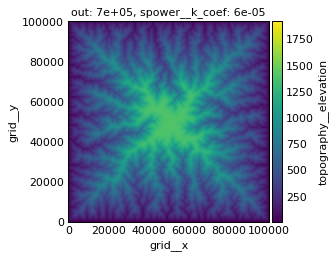
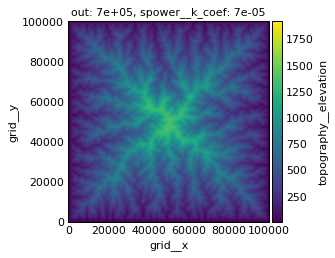
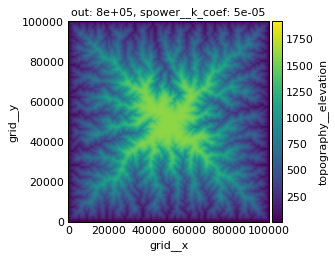
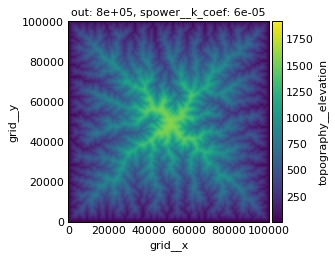
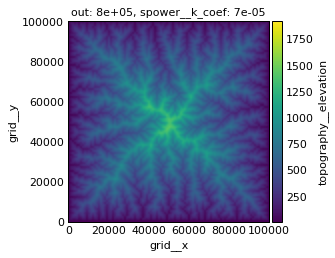
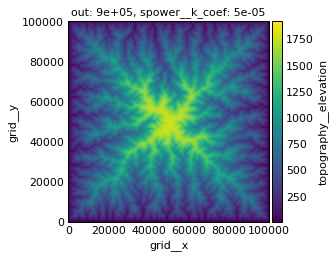
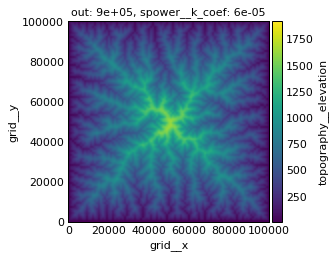
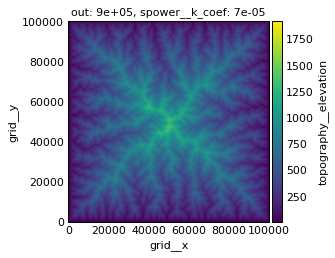
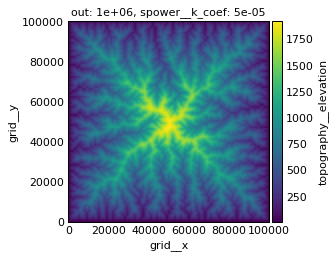
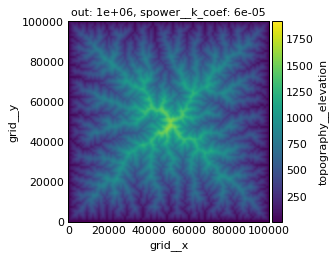
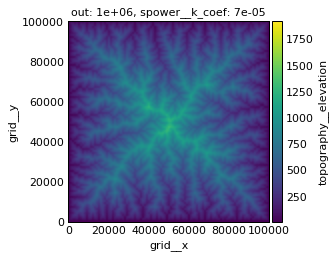

In [25]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_ds_concat_unstack.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])

## Create an alternative version of the model

xarray-simlab makes it easy to create alternative versions of a model. In the example below, instead of using constant block uplift, we set a linear uplift function on the $x$ dimension. The first step is to create a new `Process` class. 

In [26]:
from xrtopo.models.fastscape_base import StackedGridXY, BoundaryFacesXY
from xrsimlab import Process, FloatVariable, Variable, ForeignVariable


class VariableUplift(xrsimlab.Process):
    """Compute spatially variable uplift as a linear function of x."""
    
    x_coef = FloatVariable((), description='uplift function x coefficient')
    active_nodes = ForeignVariable(BoundaryFacesXY, 'active_nodes')
    x = ForeignVariable(StackedGridXY, 'x')
    uplift = Variable((), provided=True, group='exhumation')

    def initialize(self):
        mask = self.active_nodes.value
        u_rate = self.x_coef.value * self.x.value
        
        self.uplift.rate = np.zeros_like(self.x.value)
        self.uplift.rate[mask] = u_rate[mask]

    def run_step(self, dt):
        self.uplift.change = self.uplift.rate * dt


We then update the model that we used above with the new process (note the change in repr: the `uplift` process has now an `x_coef` input).

In [27]:
alt_model = fastscape_base_model.update_processes({'uplift': VariableUplift})

alt_model

<xrsimlab.Model (9 processes, 13 inputs)>
grid
    x_size     (in) nb. of nodes in x
    y_size     (in) nb. of nodes in y
    x_length   (in) total grid length in x
    y_length   (in) total grid length in y
    x_spacing  (in) node spacing in x
    y_spacing  (in) node spacing in y
    x_origin   (in) grid x-origin
    y_origin   (in) grid y-origin
boundaries
uplift
    x_coef     (in) uplift function x coefficient
flow_routing
area
spower
    k_coef     (in) stream-power constant
    m_exp      (in) stream-power drainage area exponent
    n_exp      (in) stream-power slope exponent
erosion
exhumation
topography
    elevation  (in) topographic elevation

We re-use the input Dataset created before (i.e., create a copy), remove the old input, add the new one, and then run the model.

In [28]:
alt_ds = ds.copy()

alt_ds = ds.drop('uplift__u_coef')

alt_ds.simlab.use_model(alt_model)
alt_ds.simlab.set_input_vars('uplift', x_coef=1e-7)

out_alt_ds = alt_ds.simlab.run()

You can compare the results obtained here with the results obtained above.

In [29]:
out_alt_ds_unstack = out_alt_ds.set_index(node=['grid__x', 'grid__y']).unstack('node')

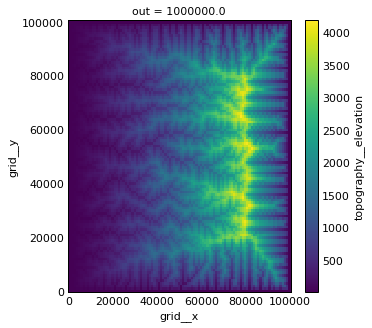

In [30]:
xr.plot.pcolormesh(out_alt_ds_unstack.isel(out=-1).topography__elevation.T,
                   size=5, aspect=1);

b':HoloMap   [out]\n   :Image   [grid__x,grid__y]   (topography__elevation)'
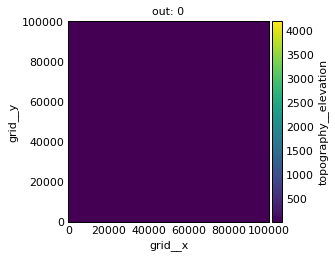
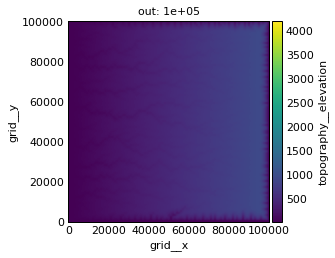
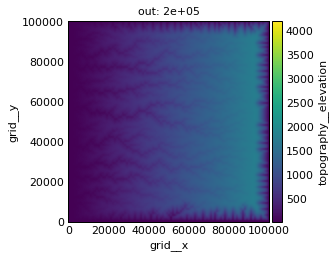
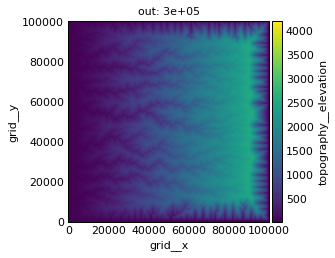
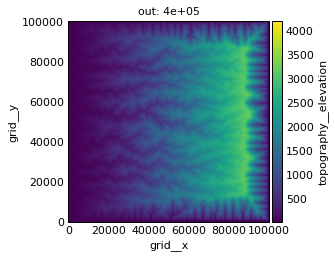
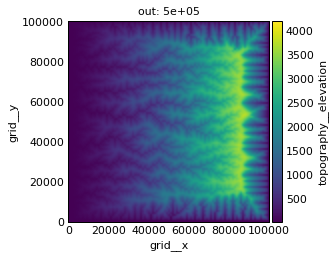
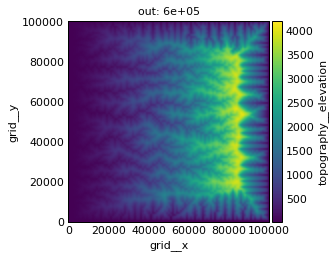
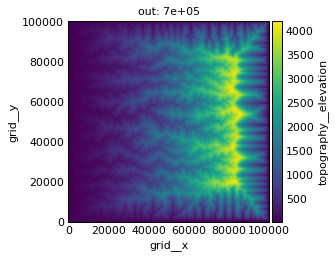
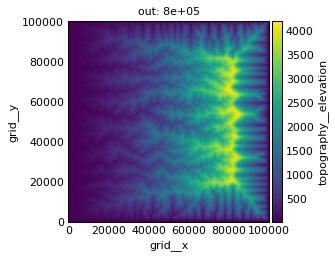
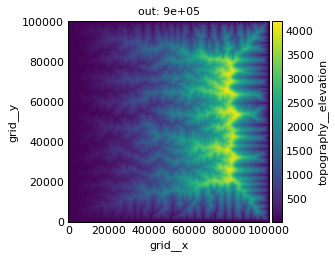
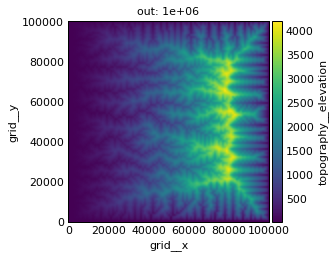

In [31]:
%%opts Image style(interpolation='bilinear', cmap='viridis') plot[colorbar=True]
hv_ds = hv.Dataset(out_alt_ds_unstack.topography__elevation)
hv_ds.to(hv.Image, ['grid__x', 'grid__y'])